<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S32_vacuum_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -U -q gtbook

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import gtsam

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables

VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs): 
    return gtbook.display.show(obj, VARIABLES, **kwargs)

# From section 3.1:
X = VARIABLES.discrete_series("X", [1], vacuum.rooms)
state_prior = gtsam.DiscreteDistribution(X[1], "0/0/1/0/0")

# Actions over time

> We can use probability language to describe systems with uncertainty in the effects of actions.

<img src="Figures3/S32-iRobot_vacuuming_robot-04.jpg" alt="Splash image with vacuuming robot in action" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

In the real world, robots do not always execute actions perfectly, for a
variety of reasons. 
To model the uncertainty when executing an action, we will once again use the
language of probability. 
We will use *conditional probability distributions* to model how we can affect the state 
of the robot by actions. 
Recall that in Chapter 2 we used conditional probabilities to model
the effects of uncertainty in sensing at a specific moment in time.
Here, we use conditional probabilities to model the uncertainty in state transitions when
actions are executed.

We can model this graphically, using directed edges to specify conditional
probabilities on variables.
We can use these graphical models to generate sample system trajectories
for a fixed sequence of actions.
Such sample trajectories can be used for planning, as we will see later in the chapter.
In addition, the graphical model approach allows us to easily extend probabilistic actions to
factored state representations.

## Primitive Actions

We will assume that our robot is equipped with navigation software that implements four
primitive actions: *move left, move right, move up, move down*,
which we will denote by *L,R,U,D*.
Together, these four actions define the **action space**.
The nominal effects of these actions (i.e., the effects of the actions without taking into account uncertainty) 
are to move the robot from the current room to an adjacent
room, according to the direction specified by the action.
For example, executing the *move down* action from the living room should take the robot into the hallway.

We can represent these actions graphically by making a slight modification to our state space graph
from the previous section.
Instead of using undirected edges to denote adjacency, each action contributes a directed edge, as shown in 
Figure <a href="#fig:Vacuum" data-reference-type="ref" data-reference="fig:Vacuum">1</a>.
Note that to simplify notation  we use *L,R,U,D*
instead of *move left, move right, move up, move down* to label the edges.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/S32-Actions.png?raw=1" id="fig:Stochastic" style="width:14cm" alt="" />
<figcaption id="fig:Stochastic" label="fig:Stochastic">Our robot is equipped with
four primitive actions: Left, Right, Up, and Down.
</figcaption>
</figure>

## Probabilistic Outcomes of Actions

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/N3-Mud.png?raw=1" id="fig:Mud" style="width:14cm" alt="" />
<figcaption id="fig:Mud" label="fig:Mud">Mobile robot driving in mud.</figcaption>
</figure>

In the real world, robots do not always execute actions perfectly, for a
variety of reasons. For example, as shown in Figure
<a href="#fig:Mud" data-reference-type="ref" data-reference="fig:Mud">2</a>,
a robot may want to drive forward in an outdoor environment but mud
under its wheels might prevent it from traveling as far as we would like.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/N3-Pick.png?raw=1" id="fig:Pickup" style="width:14cm" alt="" />
<figcaption id="fig:Pickup" label="fig:Pickup">A humanoid attempting to pick up an object.</figcaption>
</figure>

Or a robot with an articulated arm (Figure
<a href="#fig:Pickup" data-reference-type="ref" data-reference="fig:Pickup">3</a>)
might attempt to pick up an object, but fail. 


For our vacuum cleaning robot, a variety of things could go wrong: a particular doorway might be blocked, the robot might get lost, or it might take an action that is simply not available in a particular room - for example executing
*move up* in the office.

To model the uncertainty associated with executing an action, we will once again use the language of probability. 
In particular, we will use the conditional probability $P(X_{t+1}|X_{t}=x,A=a)$ to define
the the **state transition model**  model, i.e.,
the conditional probability distribution for the next state $X_{t+1}$, 
given the value $x$ of the current state $X_{t}$, and the value $a$ of the action $A$. 
Because the state space in this case involves navigation, we also call the corresponding conditional distribution 
$P(X_{t+1}|X_{t},A)$ a **motion model**.

The code below generates a motion model for moving from state $X_1$ to $X_2$ in the
form of a large conditional probability table:

In [5]:
# vacuum.action_space = ["L","R","U","D",]
# vacuum.action_spec is a string with the transition probabilities:
#  "1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
#   8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 0/2/0/0/8
#   0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
#   0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
#   0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1"
X = VARIABLES.discrete_series("X", [1, 2, 3], vacuum.rooms) # states for times 1,2 and 3
A = VARIABLES.discrete_series("A", [1, 2], vacuum.action_space) # actions for times 1 and 2
motion_model = gtsam.DiscreteConditional(X[2], [X[1], A[1]], vacuum.action_spec)
pretty(motion_model)

X1,A1,Living Room,Kitchen,Office,Hallway,Dining Room
Living Room,L,1,0,0,0,0
Living Room,R,0.2,0.8,0,0,0
Living Room,U,1,0,0,0,0
Living Room,D,0.2,0,0,0.8,0
Kitchen,L,0.8,0.2,0,0,0
Kitchen,R,0,1,0,0,0
Kitchen,U,0,1,0,0,0
Kitchen,D,0,0.2,0,0,0.8
Office,L,0,0,1,0,0
Office,R,0,0,0.2,0.8,0


It is of course very tedious to specify this table by hand.
In this case, for each of the four actions, we must compute a transition probability from
each of the five possible starting rooms to each of the five possible destination rooms:
$4*5*5=100$ entries.
In the example above, impossible transitions (e.g., moving up from the living room to any other room)
are assigned zero probability.
Other actions are assumed to have 80% chance of success (e.g., moving right from the living room
and arriving to the kitchen is assigned a transition probability of $0.8$).

Conditional probability distributions do not *have* to be specified as giant
tables. Because the state space is potentially quite large, such a
motion model is almost never explicitly specified, but
rather exploits the semantics of the states and actions to calculate the conditional distribution at run-time.
For example, rather than enumerate every possible action from every possible room, we might
determine the probability of successfully moving to an adjacent room is $0.8$, for all
rooms and for all actions, and that the probability of failing to do so is $0.2$.
If we apply this rule to each combination of action and adjacent rooms, we can
construct specific rows the table above on an as-needed basis.

### Exercises

1.  Even though the CPT above
    has 100 numbers in it, how many independent degrees of freedom do we
    actually have when specifying this CPT?

2.  Specify a *parametric* conditional density for the action models for
    the vacuuming robot that is somewhat realistic, yet not completely
    deterministic.

3.  It is possible to create models that do not reflect everyday
    physics. For example, how could we model the game “Portal”?

## Computing the Posterior Distribution for a Sequence of Actions

Suppose we apply a sequence of actions $a_1 \dots a_t$
and we wish to compute the probability distribution associated to the resulting state $X_{t+1}$?
We can accomplish this by applying the law of total probability and conditioning each
term on the applied action $a_1$.
First, recall the law of total probability:

$$
P(X_{t+1} = x_{t+1} ) = \sum_{x_t} P(X_{t+1} | X_t = x_t) P(X_t = x_t) \\
$$

Now, condition every term in the above equation on the sequence of actions
$a_1 \dots a_t$.

$$
P(X_{t+1} = x_{t+1} | a_1 \dots a_t) = \sum_{x_t} P(X_{t+1} | X_t = x_t, a_1 \dots a_t) P(X_t = x_t |a_1 \dots a_t) \\
$$

This expression may seem complex, but it can be simplified by making the following observation:
*If we know that the robot is in a specific state $x_t$ at time $t$, then the next state will depend only
on the action executed at time $t$; the previously executed actions will not affect our belief
about $X_{t+1}$.*  For example, if the robot executes the action *move down* knowing with certainty that it is in the living room at time $t$,
the sequence of actions that brought the robot to the living room (i.e., actions $a_1 \dots a_{t-1}$) do not affect our belief
about whether the robot will arrive to the hallway.
Mathematically, we can write this relationship as follows:

$$ P(X_{t+1} | X_t = x_t, a_1 \dots a_t) =  P(X_{t+1} | X_t = x_t,  a_t) $$

We can also  simplify the term $P(X_t = x_t |a_1 \dots a_t)$.
Notice that the action performed at time $t$ has no affect on the state at time $t$.
For example, if the robot executes the *move down* action
in the living room at time $t$, this actions does not change the fact that the robot was in the living room
at time *t*.
Therefore, we have

$$ P(X_t = x_t |a_1 \dots a_t) =  P(X_t = x_t |a_1 \dots a_{t-1})$$

Applying these two simplifications, we obtain the final form for our posterior:
$$
P(X_{t+1} = x_{t+1} | a_1 \dots a_t) = \sum_{x_t} P(X_{t+1} | X_t = x_t, a_t) P(X_t = x_t |a_1 \dots a_{t-1}) \\
$$

We can think of the terms in this expression as follows:
- $P(X_{t+1} = x_{t+1} | a_1 \dots a_t)$ is the posterior
- $P(X_{t+1} | X_t = x_t, a_t)$ is the motion model
- $P(X_t = x_t |a_1 \dots a_{t-1})$ is the prior.

For the initial state, when $t=0$, no actions have yet been applied, and the prior is merely 
the probability distribution at the initial state $P(X_1 = x_1)$.
Specifically, we can compute the posterior at time $t=2$ by

$$
P(X_{2} = x_{2} | a_1 ) = \sum_{x_1} P(X_{2} | X_1 = x_1, a_1) P(X_1 = x_1 ) \\
$$


## State Transition Matrices and the Belief State

In order to specify the complete posterior distribution at time $t+1$, we would need to perform the calculation above
five times, once for each of the possible next states ($L,K,O,H,D$).
This complete distribution is called the belief state, defined as

$$b_{t+1} = \left[ P(X_{t+1} = L | a_1, \dots a_t),
P(X_{t+1} = K | a_1, \dots a_t),
P(X_{t+1} = O | a_1, \dots a_t),
P(X_{t+1} = H | a_1, \dots a_t),
P(X_{t+1} = D | a_1, \dots a_t) \right]
$$


We can write the equations for the belief state in a compact form by writing the conditional probability tables as
transition matrices.
To do so, for each action, we merely gather the corresponding rows from the complete conditional probability
table into a state transition matrix.
For the action *move right*, this is illustrated below in 
Figure <a href="#fig:Vacuum" data-reference-type="ref" data-reference="fig:TM">4</a>.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/S32-transition-matrix.png?raw=1" id="fig:TM" style="width:20cm" alt="" />
<figcaption id="fig:TM" label="fig:TM">The transition matrix for the action *move right*.
</figcaption>
</figure>

If we apply the action *move right* to the initial state, by straightforward calculations, we can see that $b_2 = b_1 M_r$.
This can be generalized to a sequence of actions.
If we execute action ${\cal A}_t$ at time $t$,
the belief state $b_{t+1}$ is given by

$$b_{t+1} = b_t M_{{\cal A}_t}$$


in which $M_{\cal A}$
the conditional probability matrix for action $\cal A$ and $b_t$ is the
belief state at time $t$.
We refer to this equation as a *belief transition function* -- given the
belief at time $t$ and the action $a_t$, it can be applied to compute the belief at time $t+1$.
This result can be applied recursively to yield

$$b_{t+1} = b_1 M_{{\cal A}_1} \dots M_{{\cal A}_t}$$

## Controlled Markov Chains

In the derivation above of the belief transition function we employed a temporal decoupling property,
namely, given the state at time $t$, all actions that were applied prior to time $t$ were irrelevant
to determining the belief state $b_{t+1}$.
This is an example of what is called **the Markov property**.
Variations of this property
are essential for reducing the amount of computation required to reason probabilistically over long periods of time.

The most common example of this property arises in systems that are called **Markov chains**.
In its simplest form, a Markov chain is a sequence of random variables, $X_1, X_2, \dots $
for which

$$P(X_{t+1} | X_1 \dots X_t) = P(X_{t+1} | X_t)$$

For Markov chains, knowing $X_t$ completely decouples the past (i.e., $X_1 \dots X_{t-1}$) from the future (i.e., $X_{t+1}$).
Therefore, when reasoning about future states, we need not perform computations over the entire
history of the system; if we know $X_t$, we need only perform computations related to the present 
when reasoning about the future.

Markov chains have a nice graphical representation.
Each node corresponds to a random variable,
and directed edges specify conditional probabilities.
As an application, we can use this simple graphical model to represent
the probabilistic transitions between states, as shown below:

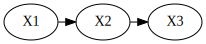

In [6]:
N = 3
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms) ## states for times 1...N
markov_chain = gtsam.DiscreteBayesNet()
markov_chain.add(state_prior)
for k in range(1, N):
    markov_chain.add(X[k+1], [X[k]], "6/1/1/1/1 1/6/1/1/1 1/1/6/1/1 1/1/6/1/1 1/1/1/1/6 ")
show(markov_chain, hints={"X":1})

Each node in this graph denotes a random variable, and therefore each node has an associated probability distribution.
If we know the distribution for the initial state $X_1$, we can iteratively compute the distributions for
$X_k$ for all $k > 1$ by evaluating the conditional distributions associated to the directed edges in the graph.

Our robot vacuum cleaner is slightly more sophisticated than this simple Markov chain, since
the robot has the ability to execute actions, and these actions affect the propagation
of probabilities through the chain.
This type of system is sometimes called a **controlled Markov chain**, since it incorporates
a control input (the actions) into the usual Markov chain.

Graphically, we can represent such a system by augmenting the graph above to include nodes that denote actions.
We use a *box* to denote nodes whose values are known.
Since the robot knows which actions it will execute, action nodes are denoted by boxes.
For our vacuuming robot, we also know the value of the initial state,
since robot always begins in the office.
Therefore, we also use a box to denote the initial state in this graph.

As an example, the code below builds the controlled Markov chain for our system up to time $t=2$.
By applying the belief transition equation above, we can compute the probabililty distribution for $X_2$,
since the action $a_1$ and the initial state $X_1$ are both completely known.

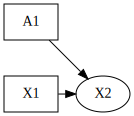

In [7]:
action_prior = gtsam.DiscreteDistribution(A[1], "1/1/1/1")
fragment = gtsam.DiscreteBayesNet()
fragment.add(motion_model)
show(fragment, hints={"A":2, "X":1}, boxes={A[1][0], X[1][0]})

For the specific example of 

Given values for the parent variables, we can examine the corresponding transition probability. For example, if we start from the $X_1=\text{Office}$ and attempt to go right, i.e., action $A_0=\text{R}$, we retrieve the following PMF over the next state $X_2$:

In [8]:
values = VARIABLES.assignment({X[1]:"Office", A[1]: "R"})
pretty(motion_model.choose(values))

X2,value
Living Room,0
Kitchen,0
Office,0.2
Hallway,0.8
Dining Room,0


This idea can be extended to arbitrarily many actions by merely adding action and state nodes for each
time $t$. The code below creates a controlled Markov chain with three states.
Try varying the value of $N$ to see other examples.

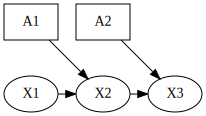

In [9]:
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space) # actions for times 1...N-1
bayesNet = gtsam.DiscreteBayesNet()
bayesNet.add(state_prior)
for k in range(1, N):
    bayesNet.add(X[k+1], [X[k], A[k]], vacuum.action_spec) # add creates conditional and adds
show(bayesNet, hints={"A":2, "X":1}, boxes={A[1][0],A[2][0]})

## Forward Simulation

We can use simulation in a graphical model to explore what a sequence of
actions will yield as outcome. 
To sample from a *conditional* distribution $p(X|Y)$ we need to make
sure we sample the variable $Y$ beforehand, and then proceed simply by
selecting the appropriate PMF depending on the value of $Y$. We can then
proceed as before using the inverse transform sampling method.

Forward sampling in a Markov chain simply repeats these steps in
succession, proceeding from left to right. 
Simulating a robot *given* an initial state $X_1$ and 
sequence of actions $A_{1},A_{2},\ldots$ is then equivalent to sampling
from this Markov chain:

1.  Set $k=1$.

2.  Simulate the effect of the next action by sampling the next state
    $x_{k+1}$ from 
    
    $$P(X_{k+1}|X_{k}=x_{k},A_{k}=a_{k}).$$

3.  Increase $k$ and return to step $2$.

Below we show how to code this up and show  4 different “rollouts” by simulating in this way. After
that, we can approximate the PMF of the final state by construction a
histogram over the possible values of the state:

In [12]:
def sample(x1, a1, a2):
    values = VARIABLES.assignment({X[1]:x1, A[1]: a1}) # initial state and action
    x2 = vacuum.rooms[bayesNet.at(1).sample(values)]
    values = VARIABLES.assignment({X[2]:x2, A[2]: a2}) # next state and action
    x3 = vacuum.rooms[bayesNet.at(2).sample(values)]
    return [x1, x2, x3]

for i in range(4):
    print(sample("Office", "R","U"))

['Office', 'Hallway', 'Living Room']
['Office', 'Hallway', 'Living Room']
['Office', 'Office', 'Office']
['Office', 'Hallway', 'Living Room']


While simple, simulating from a forward model is a rather important
technique, and underlies some of the recent successes in deep
reinforcement learning, as well as the success of DeepMind in beating
the world’s best players of the game of Go.

### Exercise

Generalize the above forward sampling algorithm to an arbitrary number of actions. Hint: you will have to make sure the variables are defined, and the Bayes Net is extended properly.

## Bayes Nets

>  Bayes nets provide a graphical language to string together conditional probabilities into a generative world model.

A Markov chain is a special case of the more general **Bayes network**.
A Bayes net is a directed *acyclic* graph (DAG) describing a factored
probability distribution a set of random variables. 
The joint distribution on the set of all variables is given as

$$P(\{X_{i}\})=\prod_{i=1}^{n}P(X_{i}|\Pi_{i})$$ 

where $n$ is the number
of variables, and $\Pi_{i}$ denotes the set of parents for variable
$X_{i}$. An example of a Bayes net is shown in the Figure below,
and it is simply a graphical representation of which random variables’s
CPT depend on which other variables. In this case, the joint
distribution can be read off as

$$P(W,X,Y,Z)=P(W|X,Z)P(X|Y,Z)P(Y|Z)P(Z).$$

Note that the order in which
we multiply the conditionals does not matter, but we typically prefer to put the parents more towards the right, as above.

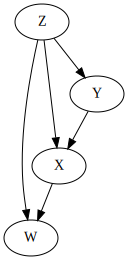

In [10]:
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")
show(wxyz)

Note that the above graph has cycles, but the cycles are only in the underlying *undirected* graph, not in the directed graph. Directed cycles, i.e. cycles with a consistent direction, are not allowed.

A Bayes net can be a very efficient representation of complex
probability distributions, as they encode the dependence and especially
independence relationships between the variables.
The Bayes net above was created assuming binary variables, and hence did not take
a lot of effort to specify, but as we saw above, even for relatively small state spaces 
the complexity of specifying CPTs can be daunting.

For example, if we
were to construct a full table of probabilities for each possible
outcome of the variables $W$,$X$,$Y$, and $Z$, the table could be quite
long. For example, if we assume they all have 10 possible values, then
the full joint has $10^{4}$ entries, i.e., $10,000$ unique values. You
can save a tiny bit, because they have to sum up to 1, so strictly
speaking we need only $9,999$ values. In contrast, we can tally how many
entries all four CPT tables have for the Bayes net above. 
In the table below we did just that:

|     CPT    | \# entries |
|-|-|
|   *P(Z)*   |      9     |
|  *P(Y\|Z)*  |     90     |
| *P(X\|Y,Z)* |     900    |
| *P(W\|X,Z)* |     900    |

For example, $P(X|Y,Z)$ has 900 entries, i.e., 9
(independent) entries for each of 100 possible combinations of $Y$ and
$Z$. Hence, the total number of parameters we need is only $1,899$,
which is way less than $9,999$.

## Factored State Representations

Factored state representations are useful if the state of the robot can
be described using features that are relatively independent of each
other. Continuing our example, the robot vacuum cleaner might also run
out of battery power, so we could associate a different variable with
its battery status, e.g., `empty`, `half`, or `full`.
The state of the robot would then be specified by the combination of
two variables: the room the robot is in, and its battery status. 
Note that now the total number of possible states
is combinatorial: if there are five rooms and three different battery
levels, we have a total of 15 possible states for the robot.

A possible model for battery life could be the following transition table, which is independent of which action was taken, and will always progress from `full` to `half`, then from `half` to `empty`, and of course once the battery is empty it will stay empty:

In [11]:
battery_states = ["full", "half", "empty"]
B = VARIABLES.discrete_series("B", range(1,N+1), battery_states)
spec_b = "9/1/0 0/9/1 0/0/1 "
pretty(gtsam.DiscreteConditional(B[2], [B[1]], spec_b))

B1,full,half,empty
full,0.9,0.1,0
half,0,0.9,0.1
empty,0,0,1


The graphical model approach allows us to easily extend probabilistic
actions to factored state representations. The code below shows one way to do it: 

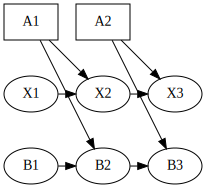

In [12]:
factored = gtsam.DiscreteBayesNet()
factored.add(state_prior)
factored.add(B[1], [], "1/0/0") # initial battery state
for k in range(1, N):
    factored.add(X[k+1], [X[k], A[k]], vacuum.action_spec) # motion model for location
    factored.add(B[k+1], [A[k], B[k]], "".join([spec_b]*4)) # battery evolution model
show(factored, hints={"A":2, "X":1, "B":0}, boxes={A[1][0],A[2][0]})

You can see that under the transition models chosen, there are now two semi-independent Markov chains. In fact, as the action sequence is *given*, the chains are truly independent.

### Exercise
Note that  do you above model makes a number of strong statements about the nature of the worlds:
1. The next battery state does not depend on where we are in the world. This seems like an OK assumption. Still, can you think of situations where this is not a realistic assumptions?
2. The next state does not depend on the battery life. Maybe this is not so defensible: clearly, if the battery is empty the robot cannot move, and the next state is the same as the previous state. It is worthwhile to think about what you would change above to make a more realistic model of the world.

## GTSAM 101

> The GTSAM concepts used in this section, explained.

Above, we use the `gtsam.DiscreteBayesNet` class, and in particular these methods:

- `add(self:, key: Tuple[int, int], parents: List[Tuple[int, int]], spec: str) -> None`: adds a conditional with the same arguments as the `gtsam.DiscreteConditional` constructor.
- `at(self, i: int) -> gtsam.DiscreteConditional`: retrieves the $i^{th}$ conditional added.

We used a sleight of hand above to extend the battery depletion model to depend on the navigation action. The following is a but of python code that replicates our specification four times:

In [13]:
"".join([spec_b]*4)

'9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 '

We then made sure to specify the action *before* the previous battery state, so that the string above works out. Below we pretty-print to make verify this came out right:

In [14]:
pretty(gtsam.DiscreteConditional(B[2], [A[2], B[1]], "".join([spec_b]*4)))

A2,B1,full,half,empty
L,full,0.9,0.1,0
L,half,0,0.9,0.1
L,empty,0,0,1
R,full,0.9,0.1,0
R,half,0,0.9,0.1
R,empty,0,0,1
U,full,0.9,0.1,0
U,half,0,0.9,0.1
U,empty,0,0,1
D,full,0.9,0.1,0


Of course, it is entirely possible to make the battery model *dependent* on the action chosen.

Finally, a word about the graphs above. You might wonder, why these graphs come out so beautifully positioned, e.g., to indicate time from left to right. This was accomplished with the `hints` argument, which positions variables series at an appropriate height. Similarly, the `boxes` argument (which takes `gtsam.Keys`, not tuples) indicates which variables should considered as given.

These arguments are handled in the [`gtbook` library](https://gtbook.github.io/gtbook/), and are passed on in the appropriate format to the underlying GTSAM `dot` methods.